### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] Eye dataset 클래스

In [3]:
class MultimodalEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # 이미지 불러오기
        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        # 임상정보: gender -> one-hot 인코딩, norm_age
        norm_age = torch.tensor(item['age'], dtype=torch.float32)
        gender = item['gender']  # 0 or 1
        gender_one_hot = torch.tensor([1, 0], dtype=torch.float32) if gender == 0 else torch.tensor([0, 1], dtype=torch.float32)

        clinical = torch.cat([norm_age.unsqueeze(0), gender_one_hot])  # shape: [3]

        label = torch.tensor(item['label'], dtype=torch.long)

        return left_img, right_img, clinical, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable multimodal samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [5]:
# 경로 설정
json_file = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 학습용 데이터셋 (group 1)
train_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=1,
    include_0_9mm=True,
    transform=TrainTransform
)

# 검증용 데이터셋 (group 2)
val_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=2,
    include_0_9mm=True,
    transform=ValidTransform
)

# 테스트용 데이터셋 (group 3)
test_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=3,
    include_0_9mm=True,
    transform=ValidTransform
)

from torch.utils.data import DataLoader

# 최적화 설정: num_workers=2, pin_memory=True
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable multimodal samples for group 1: 2603
usable multimodal samples for group 2: 200
usable multimodal samples for group 3: 100


### [6] 모델 정의

In [6]:
import torch
import torch.nn as nn
import timm

class SiameseEfficientNetV2MultimodalClassifier(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(SiameseEfficientNetV2MultimodalClassifier, self).__init__()

        # EfficientNetV2 백본 (feature extractor)
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # 임상정보 임베딩
        self.clinical_fc = nn.Sequential(
            nn.Linear(3, 128),  # 성별 one-hot (2) + 정규화 나이 (1)
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # 분류기: 이미지 feature + 임상 feature
        self.classifier = nn.Sequential(
            nn.Linear(1280 * 2 + 128, 512),  # 왼쪽 + 오른쪽 이미지 + 임상
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)  # 이진 분류
        )

    def forward(self, left, right, clinical):
        # 왼쪽, 오른쪽 이미지 피처 추출
        left_feat = self.backbone(left)     # (B, 1280)
        right_feat = self.backbone(right)   # (B, 1280)
        image_feat = torch.cat([left_feat, right_feat], dim=1)  # (B, 2560)
        image_feat = self.dropout(image_feat)

        # 임상정보 임베딩
        clinical_feat = self.clinical_fc(clinical)  # (B, 128)

        # 최종 feature 결합
        fused = torch.cat([image_feat, clinical_feat], dim=1)  # (B, 2688)
        output = self.classifier(fused)  # (B, 2)

        return output


### [7] FocalLoss 클래스 정의

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프 + loss 그래프

In [12]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = SiameseEfficientNetV2MultimodalClassifier(dropout_p=0.3).to(device)

# 손실 함수
criterion = FocalLoss()

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 하이퍼파라미터
epochs = 20
best_val_loss = float('inf')

# 손실 저장 리스트
train_losses = []
val_losses = []
val_accuracies = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for left, right, clinical, labels in train_loader:
        left, right = left.to(device), right.to(device)
        clinical, labels = clinical.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left, right, clinical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, clinical, labels in val_loader:
            left, right = left.to(device), right.to(device)
            clinical, labels = clinical.to(device), labels.to(device)

            outputs = model(left, right, clinical)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    # Best 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_effnetv2_multimodal2_1e-3.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# 손실 기록 저장
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}

with open('/content/drive/MyDrive/cv_project/01unimodal/loss_history_effnetv2_multimodal2_1e-3.json', 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_effnetv2_multimodal2_1e-3.json 저장 완료!")


Best model updated at epoch 1 (Val Loss: 0.1335)
Epoch 1/20 | Train Loss: 0.1393 | Val Loss: 0.1335 | Val Acc: 0.7600 | LR: 0.001000
Epoch 2/20 | Train Loss: 0.1169 | Val Loss: 0.1981 | Val Acc: 0.5200 | LR: 0.001000
Best model updated at epoch 3 (Val Loss: 0.1217)
Epoch 3/20 | Train Loss: 0.1160 | Val Loss: 0.1217 | Val Acc: 0.8000 | LR: 0.001000
Epoch 4/20 | Train Loss: 0.1122 | Val Loss: 0.1485 | Val Acc: 0.7250 | LR: 0.001000
Epoch 5/20 | Train Loss: 0.1113 | Val Loss: 0.1563 | Val Acc: 0.6750 | LR: 0.001000
Epoch 6/20 | Train Loss: 0.1103 | Val Loss: 0.1680 | Val Acc: 0.6900 | LR: 0.001000
Epoch 7/20 | Train Loss: 0.1097 | Val Loss: 0.1617 | Val Acc: 0.6650 | LR: 0.001000
Epoch 8/20 | Train Loss: 0.1094 | Val Loss: 0.1724 | Val Acc: 0.6600 | LR: 0.001000
Epoch 9/20 | Train Loss: 0.1116 | Val Loss: 0.1469 | Val Acc: 0.7050 | LR: 0.001000
Epoch 10/20 | Train Loss: 0.1107 | Val Loss: 0.1489 | Val Acc: 0.7050 | LR: 0.001000
Epoch 11/20 | Train Loss: 0.1120 | Val Loss: 0.1391 | Val Acc

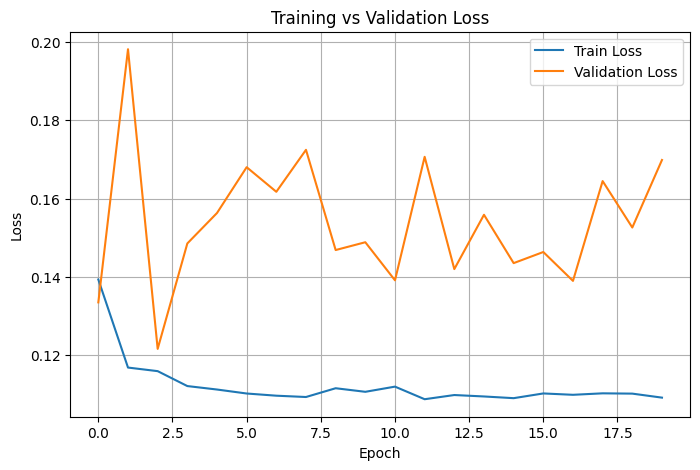

In [13]:
# 학습 종료 후 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### [9] predict_result.json 저장

In [14]:
from tqdm import tqdm
import torch
import json

# 모델 로드
model = SiameseEfficientNetV2MultimodalClassifier(dropout_p=0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_effnetv2_multimodal2_1e-3.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left, right, clinical, labels in tqdm(test_loader, desc="Predicting"):
        left = left.to(device)
        right = right.to(device)
        clinical = clinical.to(device)

        outputs = model(left, right, clinical)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for true, pred, prob in zip(labels.cpu(), preds.cpu(), probs[:, 1].cpu()):
            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item())  # class 1 (두꺼워진) 확률
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_effnetv2_multimodal2_1e-3.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_effnetv2_multimodal2_1e-3.json


### [10] 평가 + AUC Curve 그리기

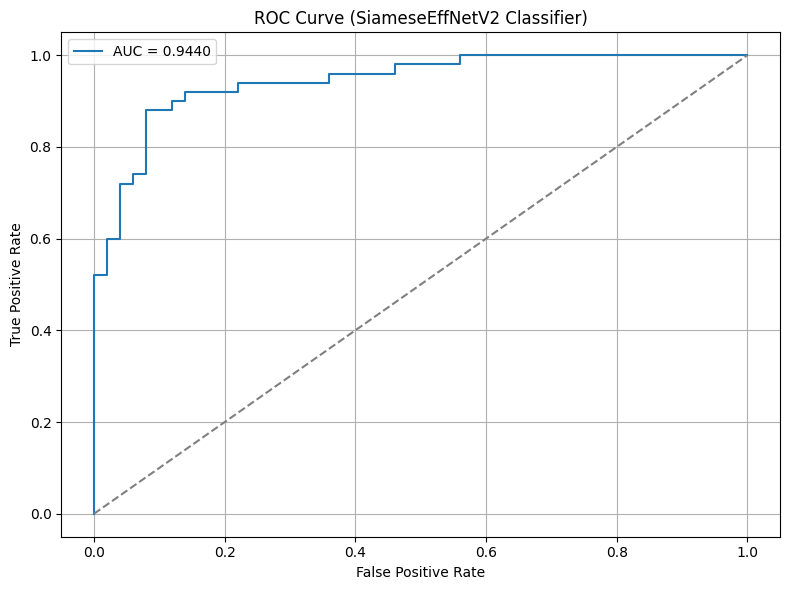

정확도 (Accuracy): 0.8500
AUC-ROC: 0.9440

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.91      0.78      0.84        50
   Thickened       0.81      0.92      0.86        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100


Confusion Matrix:
[[39 11]
 [ 4 46]]


In [15]:
import json
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_effnetv2_multimodal2_1e-3.json", "r") as f:
    results = json.load(f)

# true, pred, prob 분리
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# AUC-ROC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

# ROC Curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SiameseEffNetV2 Classifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 추가 성능 출력
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))




---


## 전체 성능 요약
[단일모달 모델]
- 정확도 (Accuracy): 75.00%
- AUC-ROC: 82.58%

[현재 모델]
- 학습률: 1e-4
- 정확도 (Accuracy): 77.00%
- AUC-ROC: 85.08%